A spectral analysis of crimes in San Francisco
==============================================

This notebook contains all the code to reproduce a study with the same title, submitted to UrbanGIS '16.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as pylab

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("data/SFPD_Incidents_-_from_1_January_2003.csv", quotechar='"')
train['Dates'] = pd.to_datetime(train['Date']+" "+train['Time'])
train.head(1)

,﻿IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Dates
0,110914565,WARRANTS,WARRANT ARREST,Friday,05/29/2015,16:42,SOUTHERN,"ARREST, BOOKED",BRYANT ST / 8TH ST,-122.406971,37.772527,"(37.7725273607571, -122.406970988225)",11091456563010,2015-05-29 16:42:00


In [4]:
ts = train[train['Category'] == "BURGLARY"].set_index('Dates')
ts2 = ts['Category'].resample('m', how='count')
ts4 = ts['Category'].resample('d', how='count')

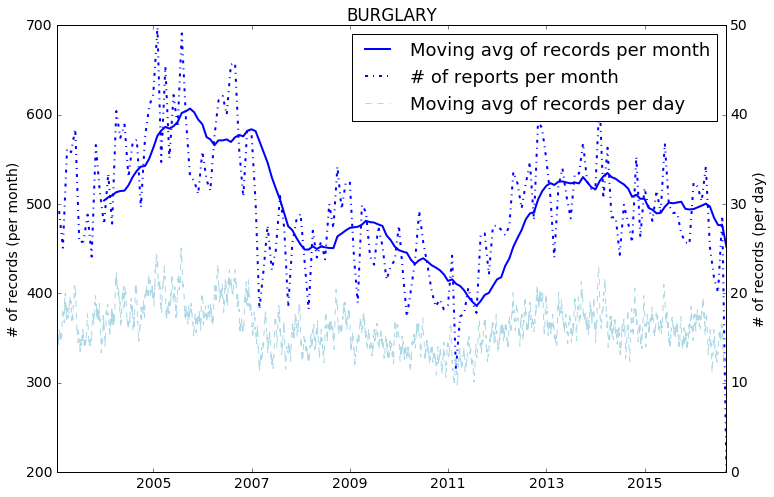

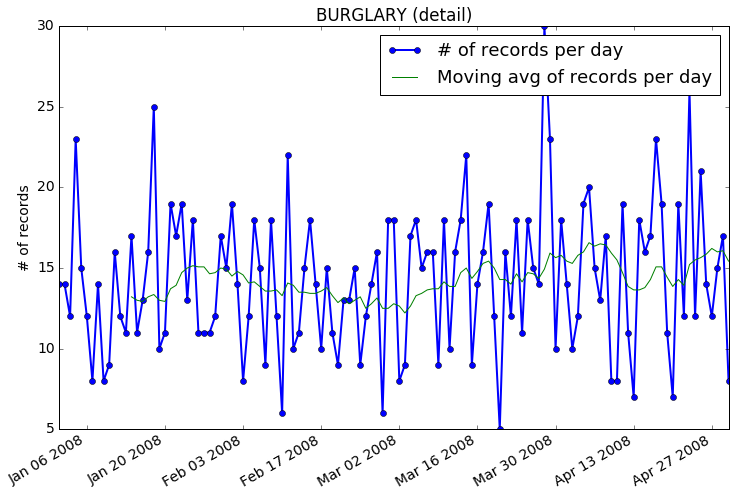

In [5]:
%matplotlib inline

pylab.rcParams['figure.figsize'] = 12, 8
pylab.rcParams['font.size'] = 14

fig, ax1 = pylab.subplots()
pylab.title("BURGLARY")
ts4 = ts4[ts4!=0]
ax1.plot(pd.rolling_mean(ts2, window=12), linewidth=2, color="blue", label="Moving avg of records per month")

ax2 = ax1.twinx()
ax2.set_ylim([0, 50])
ax2.plot(pd.rolling_mean(ts4, window=14), color="lightblue", ls="--", label="Moving avg of records per day")
ax1.plot(ts2.index, ts2, linewidth=2, ls="-.", color="blue", label="# of reports per month")

ax1.set_ylabel("# of records (per month)")
ax2.set_ylabel("# of records (per day)")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0, fontsize=18)

##2nd plot

fig = pylab.figure()
partial4 = ts4["01/01/2008":"30/04/2008"]
pylab.title("BURGLARY (detail)")
pylab.plot(partial4.index, partial4,"o-", linewidth=2, label="# of records per day")
pd.rolling_mean(partial4, window=14).plot(label="Moving avg of records per day")
pylab.ylabel("# of records")
pylab.xlabel("")
pylab.legend(fontsize=18)


**Figure 1: Evolution over time of burglaries in San Francisco **

In [6]:
import datetime
dt4 = ts4 - pd.rolling_mean(ts4, window=14)
t = pd.Series(dt4.dropna().index).apply(lambda row : ((row.date()-datetime.date(2003, 1, 1)).days))
y_obs = dt4.dropna()
dy = np.ones(y_obs.size)

In [7]:
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
    
period = np.linspace(1.1, 54, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

In [8]:
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=100, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

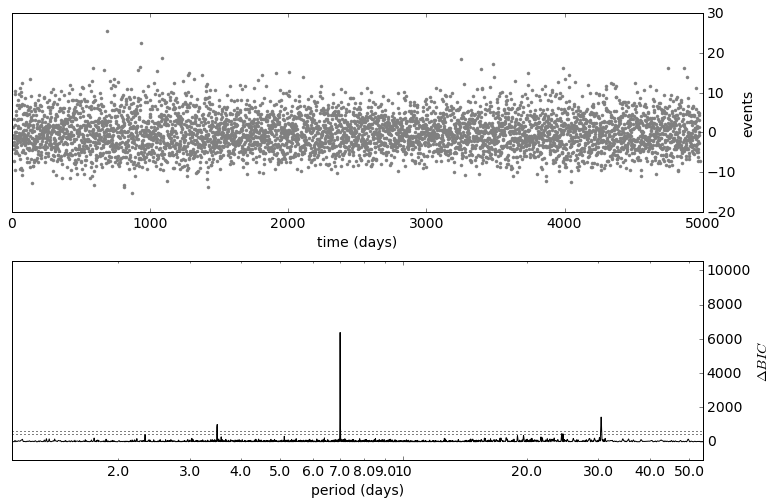

In [9]:

plt = pylab


def plot_periodogram():

    fig = plt.figure()
    fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

    ax = fig.add_subplot(211)
    ax.plot(t, y_obs, lw=1, ls="None",marker=".", color='gray')
    ax.set_xlabel('time (days)')

    ax.yaxis.tick_right()

    ax.yaxis.set_label_position("right")
    ax.set_ylabel("events")

    ax1 = fig.add_subplot(212, xscale='log')
    ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
    ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
    ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')



    ax1.set_xlim(period[0], period[-1])
    ax1.set_ylim(-0.01, 0.1)

    ax1.set_xlabel(r'period (days)')

    ax1.set_yticks([])

    ax2 = ax1.twinx()
    ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
    ax2.set_ylabel(r'$\Delta BIC$')

    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_major_locator(plt.LogLocator(10))
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))
    return

plot_periodogram()

plt.show()

**Figure 2: Periodogram of burglaries after detrending**

In [10]:
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
    
df = train.set_index('Dates')
pgs = {}
sig1 = {}
sig5 = {}
for cat, events in df.groupby('Category'):
    ts = events['Category'].resample('d', how='count')
    ts = ts[ts!=0]
    ts = ts - pd.rolling_mean(ts, window=14)
    ts = ts.dropna()
    t = range(ts.dropna().size)
    y_obs = ts.dropna()
    dy = np.ones(y_obs.size) 
    period = np.linspace(1.1, 50, 10000)
    omega = 2 * np.pi / period
    pgs[cat] = lomb_scargle(t, y_obs, dy, omega, generalized=True)
    #significance levels
    #D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
    #                           N_bootstraps=100, random_state=0) #set higher bootstrap
    #sig1[cat], sig5[cat] = np.percentile(D, [99, 95])

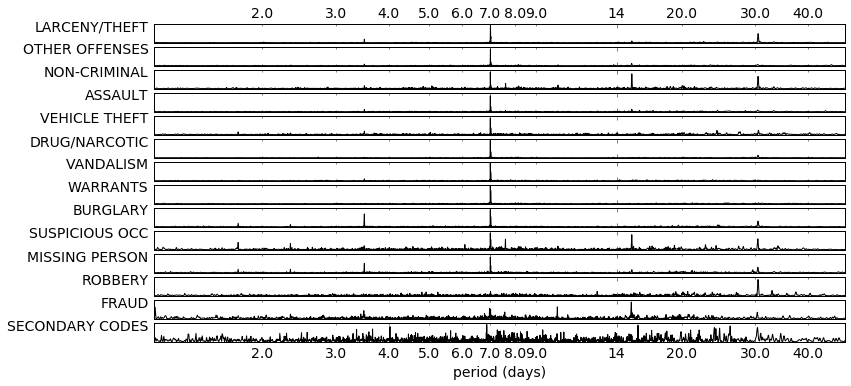

In [11]:
plt = pylab
pylab.rcParams['figure.figsize'] = 12, 16

fig = plt.figure()
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)
i=1
rows = len(pgs)
for cat in train[train['Category'] != 'TREA']['Category'].value_counts()[:14].index:
    
    PS = pgs[cat]

    try:
        ax1 = fig.add_subplot(rows, 1, i, xscale='log')
        if i==1: ax1.xaxis.set_ticks_position("top")
        
        ax1.get_xaxis().set_ticks([14])

        ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)

        ax1.set_xlim(period[0],49)

        ax1.set_ylabel(cat, rotation='horizontal', ha = 'right' )

        ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
        ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))

        ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))
        
        ax1.get_yaxis().set_ticks([])

        i+=1
    except ValueError:
        print "no data for "+cat
        pass

    
ax1.set_xlabel(r'period (days)')

ax1.get_xaxis().set_ticks([14])


plt.show()

**Figure 3: Periodogram of most frequent categories of crime**

In [12]:
mapdata = np.loadtxt("data/sf_map_copyright_openstreetmap_contributors.txt")

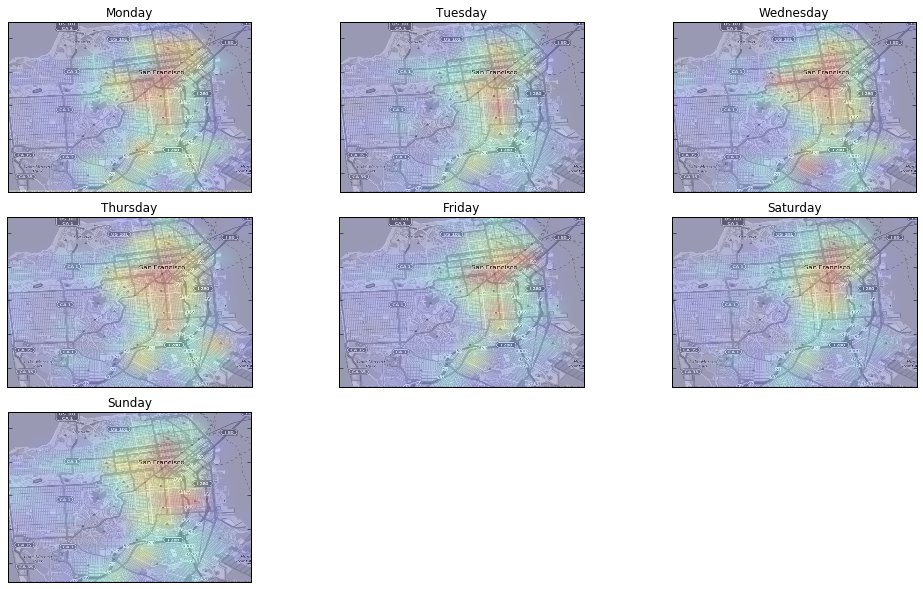

In [17]:
%matplotlib inline
fig = plt.figure(figsize = (14, 8.27))
#latitude and longitude of map data
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
new_lon_lat_box = [-122.509895418239, -122.365565425353, 37.7085327739224, 37.809670701323903]


ax = fig.add_subplot(331)
ax.set_title("Monday")
ax.ticklabel_format(axis='both',style='plain', useOffset=False)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                      extent=lon_lat_box)

data = train[train["Category"]== "VEHICLE THEFT"][train["Dates"].dt.year == 2015][train["DayOfWeek"]=="Monday"]

heatmap, xedges, yedges = np.histogram2d(data.X, data.Y,  bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.set_ylim(new_lon_lat_box[2], new_lon_lat_box[3])

ax.imshow(heatmap.T, extent=extent, origin = 'lower', alpha=0.2)
#plt.plot(data.X, data.Y, marker=".", ls="None")

ax = fig.add_subplot(332)
ax.set_title("Tuesday")
ax.ticklabel_format(axis='both',style='plain', useOffset=False)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                      extent=lon_lat_box)

data = train[train["Category"]== "VEHICLE THEFT"][train["Dates"].dt.year == 2015][train["DayOfWeek"]=="Tuesday"]
#plt.plot(data.X, data.Y, marker=".", ls="None")
heatmap, xedges, yedges = np.histogram2d(data.X, data.Y,  bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.set_ylim(new_lon_lat_box[2], new_lon_lat_box[3])


ax.imshow(heatmap.T, extent=extent, origin = 'lower', alpha=0.2)
ax = fig.add_subplot(333)
ax.set_title("Wednesday")
ax.ticklabel_format(axis='both',style='plain', useOffset=False)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                      extent=lon_lat_box)

data = train[train["Category"]== "VEHICLE THEFT"][train["Dates"].dt.year == 2015][train["DayOfWeek"]=="Wednesday"]
#plt.plot(data.X, data.Y, marker=".", ls="None")
heatmap, xedges, yedges = np.histogram2d(data.X, data.Y,  bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.set_ylim(new_lon_lat_box[2], new_lon_lat_box[3])

ax.imshow(heatmap.T, extent=extent, origin = 'lower', alpha=0.2)
ax = fig.add_subplot(334)
ax.set_title("Thursday")
ax.ticklabel_format(axis='both',style='plain', useOffset=False)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                      extent=lon_lat_box)

data = train[train["Category"]== "VEHICLE THEFT"][train["Dates"].dt.year == 2015][train["DayOfWeek"]=="Thursday"]
heatmap, xedges, yedges = np.histogram2d(data.X, data.Y, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.set_ylim(new_lon_lat_box[2], new_lon_lat_box[3])


ax.imshow(heatmap.T, extent=extent, origin = 'lower', alpha=0.2)

ax = fig.add_subplot(335)
ax.set_title("Friday")
ax.ticklabel_format(axis='both',style='plain', useOffset=False)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                      extent=lon_lat_box)

data = train[train["Category"]== "VEHICLE THEFT"][train["Dates"].dt.year == 2015][train["DayOfWeek"]=="Friday"]
#plt.plot(data.X, data.Y, marker=".", ls="None")
heatmap, xedges, yedges = np.histogram2d(data.X, data.Y, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.set_ylim(new_lon_lat_box[2], new_lon_lat_box[3])


ax.imshow(heatmap.T, extent=extent, origin = 'lower', alpha=0.2)
ax = fig.add_subplot(336)
ax.set_title("Saturday")
ax.ticklabel_format(axis='both',style='plain', useOffset=False)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                      extent=lon_lat_box)

data = train[train["Category"]== "VEHICLE THEFT"][train["Dates"].dt.year == 2015][train["DayOfWeek"]=="Saturday"]
#plt.plot(data.X, data.Y, marker=".", ls="None")
heatmap, xedges, yedges = np.histogram2d(data.X, data.Y, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.set_ylim(new_lon_lat_box[2], new_lon_lat_box[3])


ax.imshow(heatmap.T, extent=extent, origin = 'lower', alpha=0.2)
ax = fig.add_subplot(337)
ax.set_title("Sunday")
ax.ticklabel_format(axis='both',style='plain', useOffset=False)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
                      extent=lon_lat_box)

data = train[train["Category"]== "VEHICLE THEFT"][train["Dates"].dt.year == 2015][train["DayOfWeek"]=="Sunday"]
#plt.plot(data.X, data.Y, marker=".", ls="None")
heatmap, xedges, yedges = np.histogram2d(data.X, data.Y,  bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.set_ylim(new_lon_lat_box[2], new_lon_lat_box[3])


ax.imshow(heatmap.T, extent=extent, origin = 'lower', alpha=0.2)
plt.tight_layout()

#plt.savefig("heat.png", format="png", dpi=160, bbox_inches="tight", pad_inches=0.1, transparent=True)

**Figure 4: Heatmap of vehicle thefts in different days of the week, in 2015**